<a href="https://colab.research.google.com/github/aldoalprak/bangkit_project1/blob/master/Bangkit-Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# Please upload the dataset to your own google drive from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/metadata or https://drive.google.com/drive/u/1/folders/1xuZMvG8rOlXVXWTXel26wuCayxP0TK9s
# With exact directory shown below
!ls "/content/drive/My Drive/chest_xray/"

test  train  val


In [0]:
## Load the data

train_dir = os.path.join("/content/drive/My Drive/chest_xray/train")
validation_dir = os.path.join("/content/drive/My Drive/chest_xray/val")
test_dir = os.path.join("/content/drive/My Drive/chest_xray/test")

train_normal_dir = os.path.join(train_dir, "NORMAL")
train_pneumonia_dir = os.path.join(train_dir, "PNEUMONIA")

validation_normal_dir = os.path.join(validation_dir, "NORMAL")
validation_pneumonia_dir = os.path.join(validation_dir, "PNEUMONIA")

test_normal_dir = os.path.join(test_dir, "NORMAL")
test_pneumonia_dir = os.path.join(test_dir, "PNEUMONIA")


In [18]:
## Understand the data

num_normal_train = len(os.listdir(train_normal_dir))
num_pneumonia_train = len(os.listdir(train_pneumonia_dir))

num_normal_validation = len(os.listdir(validation_normal_dir))
num_pneumonia_validation = len(os.listdir(validation_pneumonia_dir))

num_normal_test = len(os.listdir(test_normal_dir))
num_pneumonia_test = len(os.listdir(test_pneumonia_dir))

total_train = num_normal_train + num_pneumonia_train
total_validation = num_normal_validation + num_pneumonia_validation
total_test = num_normal_test + num_pneumonia_test

train_samples = 3000
test_samples = 2000

print("total training normal lung = ", num_normal_train)
print("total training pneumonia lung = ", num_pneumonia_train)
print("==================================")
print("total validation normal lung = ", num_normal_validation)
print("total validation pneumonia lung = ", num_pneumonia_validation)
print("==================================")
print("total test normal lung = ", num_normal_test)
print("total test pneumonia lung = ", num_pneumonia_test)
print("==================================")
print("total train data = ", total_train)
print("total validation data = ", total_validation)
print("total test data = ", total_test)

total training normal lung =  1342
total training pneumonia lung =  3876
total validation normal lung =  9
total validation pneumonia lung =  9
total test normal lung =  234
total test pneumonia lung =  390
total train data =  5218
total validation data =  18
total test data =  624


In [0]:
batch_size = 150
epochs = 20
IMG_WIDTH = 300
IMG_HEIGHT = 200

In [20]:
## Data Preparation
train_image_generator = ImageDataGenerator(
                          rescale=1./255, 
                          horizontal_flip=True,
                          rotation_range=45,
                          zoom_range=0.5,
                          width_shift_range=.15,
                          height_shift_range=.15,
                        )
test_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    batch_size = batch_size,
    directory = train_dir,
    shuffle = True,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode="binary"
)

validation_data_gen = validation_image_generator.flow_from_directory(
    batch_size = batch_size,
    directory = validation_dir,
    shuffle = True,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode="binary"
)

test_data_gen = test_image_generator.flow_from_directory(
    batch_size = batch_size,
    directory = test_dir,
    shuffle = True,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode="binary"
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


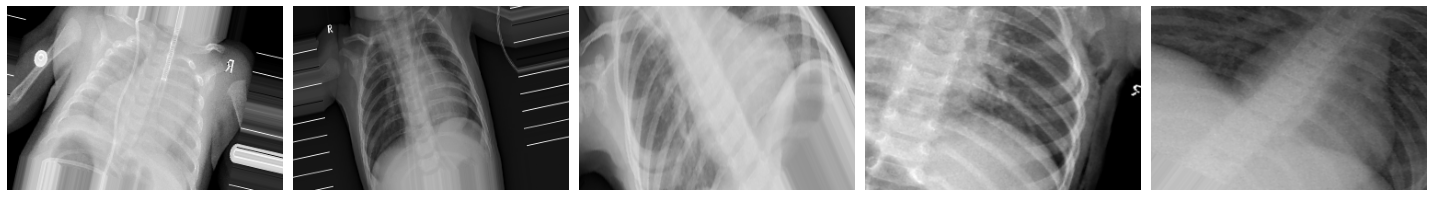

In [21]:
## Visualize training image

sample_training_image, _ = next(train_data_gen)

def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis("off")
  plt.tight_layout()
  plt.show()

plotImages(sample_training_image[:5])

In [0]:
## model creation

convolutional_blocks = [
  Conv2D(16,3, padding="same", activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  MaxPooling2D(pool_size=(2,2)),
  Conv2D(32, 3, padding="same", activation="relu"),
  MaxPooling2D(pool_size=(2,2)),
  Conv2D(64,3, padding="same", activation="relu"),
  MaxPooling2D(pool_size=(2,2)),
  Flatten(),
  Dense(64, activation="relu"),
  Dropout(0.5),
  Dense(1)
]

model = Sequential(convolutional_blocks)

In [0]:
## compiing model

model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
## summarize model

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 200, 300, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 100, 150, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 75, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 25, 37, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 59200)            

In [30]:
## train the model
## note: we switch validation data to test data because the test data > validation_data

history = model.fit(
    train_data_gen,
    steps_per_epoch= train_samples // batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps= test_samples // batch_size
)

Epoch 1/20
20/20 [==============================] - 240s 12s/step - loss: 0.6707 - accuracy: 0.5701 - val_loss: 0.6516 - val_accuracy: 0.6349
Epoch 2/20
20/20 [==============================] - 242s 12s/step - loss: 0.4433 - accuracy: 0.7897 - val_loss: 0.4564 - val_accuracy: 0.7990
Epoch 3/20
20/20 [==============================] - 239s 12s/step - loss: 0.4116 - accuracy: 0.8004 - val_loss: 0.4493 - val_accuracy: 0.8346
Epoch 4/20
20/20 [==============================] - 244s 12s/step - loss: 0.4023 - accuracy: 0.8063 - val_loss: 0.4542 - val_accuracy: 0.8473
Epoch 5/20
20/20 [==============================] - 242s 12s/step - loss: 0.3610 - accuracy: 0.8436 - val_loss: 0.4527 - val_accuracy: 0.7786
Epoch 6/20
20/20 [==============================] - 245s 12s/step - loss: 0.3776 - accuracy: 0.8427 - val_loss: 0.4677 - val_accuracy: 0.8522
Epoch 7/20
20/20 [==============================] - 236s 12s/step - loss: 0.3557 - accuracy: 0.8523 - val_loss: 0.4010 - val_accuracy: 0.8441
Epoch 

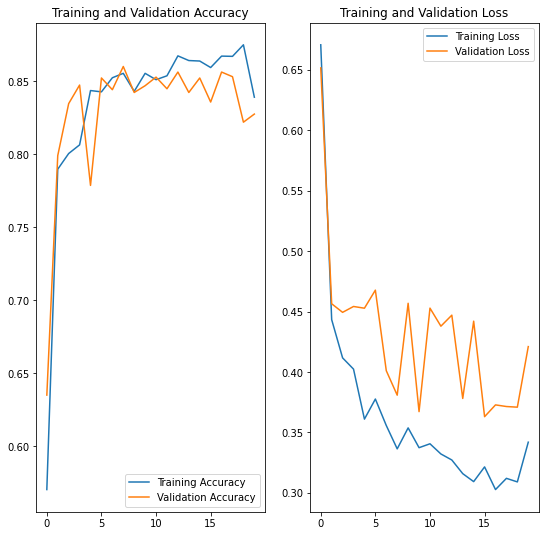

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
## img prediction testing
## note: we switch validation data to test data because the test data > validation_data
train_eval = model.evaluate(validation_data_gen, steps=total_validation/batch_size)
print("testing accuracy ==>",train_eval[1]*100)

1/0 [==========================================================================================================================================================================================================================================================] - 0s 2ms/step - loss: 0.4687 - accuracy: 0.8125
testing accuracy ==> 81.25
